<a href="https://colab.research.google.com/github/derrodo61/notebooks/blob/main/clean_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq duckduckgo-images-api
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which i

In [3]:
from fastbook import search_images_ddg
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

In [5]:
# search for test photos

urls = search_images('Scarlett Johansson photos', max_images=3)
urls

Searching for 'Scarlett Johansson photos'


(#3) ['https://celebmafia.com/wp-content/uploads/2020/06/scarlett-johansson-under-the-skin-premiere-in-venice-19.jpg','http://1.bp.blogspot.com/-cezIoFeHTNQ/TaexTlub2SI/AAAAAAAAFI0/_BRaf1slp3M/s1600/scarlett-johansson13903.jpg','http://www.vidigy.com/wp-content/uploads/2010/11/Scarlett_Johansson_1110_06.jpg']

In [6]:
# download 1 test photo

path = '/content/samples/scarlett/'
dest = Path(path)
dest.mkdir(exist_ok=True, parents=True)
url = urls[1]
fpath = download_url(url, dest)
fpath

Path('/content/samples/scarlett/scarlett-johansson13903.jpg')

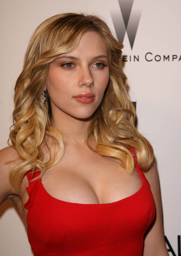

In [7]:
# show the downloaded photo

from fastai.vision.all import *

im = Image.open(fpath)
im.to_thumb(256,256)

In [8]:
# download 90 images of each,  Angelina and Scarlett

searches = 'Angelina Jolie','Scarlett Johansson'

path = Path('angelina_or_scarlett')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo',max_images=30))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} photo',max_images=30))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} photo',max_images=30))
    sleep(10)  # Pause between searches to avoid over-loading server

    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Angelina Jolie photo'
Searching for 'Angelina Jolie photo'
Searching for 'Angelina Jolie photo'
Searching for 'Scarlett Johansson photo'
Searching for 'Scarlett Johansson photo'
Searching for 'Scarlett Johansson photo'


In [10]:
# remove photos which cannot be opened

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

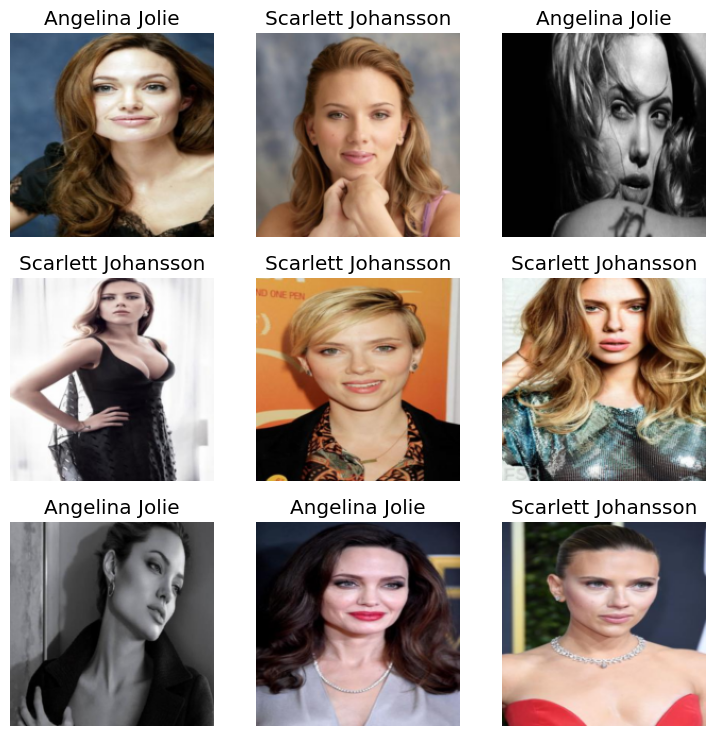

In [11]:
# create the data set

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=9)

# resize option:
# Resize(192, method='squish')
# Resize(192, method='pad', pad_mode="zeros")

In [12]:
# train

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.930909,1.204158,0.411765,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.433944,0.425400,0.264706,00:01
1,0.280371,0.013243,0.000000,00:01
2,0.194471,0.006160,0.000000,00:01
3,0.143057,0.004905,0.000000,00:01


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


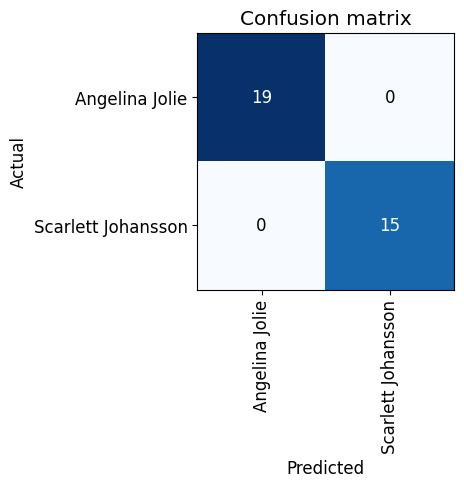

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()